Evaluate the performance of different types of optimizer on a LeNet-5 network usingMNIST data. At least you need to evaluate SGD, AdaGrad, RMSprop

In [ ]:
#In this one off code I have experimented with tanh function for Problem -1
#The intention was to see how the loss function changes if the non-linear activation function is changed from ReLu to Tanh
#In the project report btw, only the ReLU loss plots results are added (to keep the discussed model consistent)

#Consider this model as an auxiliary study only. 

#Especially note how the model summary figure shows slight variation in the model architecture

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import time

In [3]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.01
BATCH_SIZE = 128
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [7]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [8]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    
    
    return model, optimizer, epoch_loss

In [9]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [10]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    
    time0 = time.time()
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
        
    time1 = time.time() 
    print ('Traning and Testing total excution time is: %s seconds ' % (time1-time0)) 

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [11]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [12]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.log_softmax(logits, dim=1)
        
        
        return logits, probs

In [13]:
ROW_IMG = 10
N_ROWS = 5

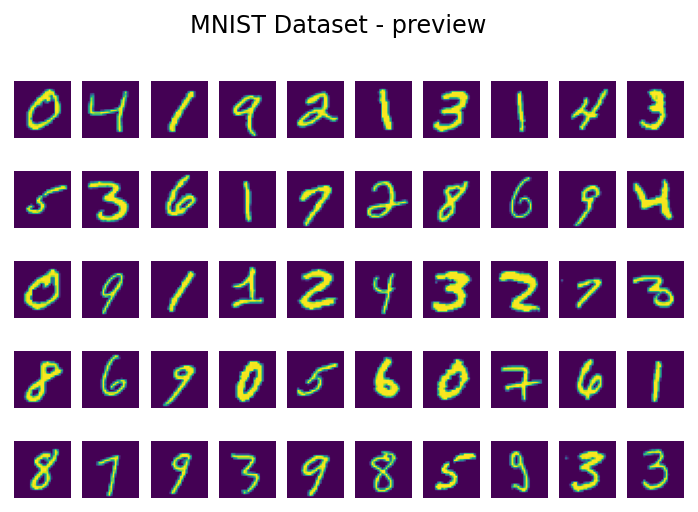

In [14]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

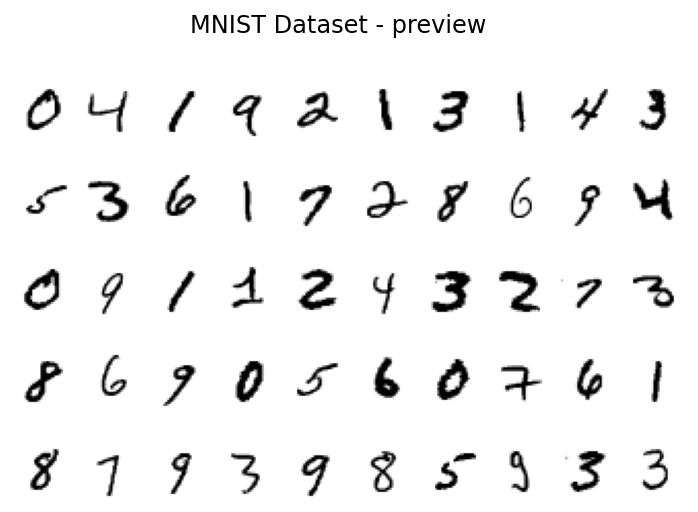

In [15]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')


fig.suptitle('MNIST Dataset - preview');

In [16]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [17]:
#pip install torch-summary

In [18]:
from torchvision import models
from torchsummary import summary

In [19]:
print(model)

summary(model)

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       156
|    └─Tanh: 2-2                         --
|    └─AvgPool2d: 2-3                    --
|    └─Conv2d: 2-4                       2,416
|    └─Tanh: 2-5                         --
|    └─AvgPool2d: 2-6                    --
|    └─Conv2d: 2-7                       48,120
|    └─Tanh: 2-8                        

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       156
|    └─Tanh: 2-2                         --
|    └─AvgPool2d: 2-3                    --
|    └─Conv2d: 2-4                       2,416
|    └─Tanh: 2-5                         --
|    └─AvgPool2d: 2-6                    --
|    └─Conv2d: 2-7                       48,120
|    └─Tanh: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       10,164
|    └─Tanh: 2-10                        --
|    └─Linear: 2-11                      850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0

01:11:44 --- Epoch: 0	Train loss: 0.7507	Valid loss: 0.2570	Train accuracy: 92.11	Valid accuracy: 92.57
01:12:07 --- Epoch: 1	Train loss: 0.2024	Valid loss: 0.1384	Train accuracy: 95.64	Valid accuracy: 95.81
01:12:30 --- Epoch: 2	Train loss: 0.1234	Valid loss: 0.0927	Train accuracy: 97.14	Valid accuracy: 97.20
01:12:52 --- Epoch: 3	Train loss: 0.0899	Valid loss: 0.0756	Train accuracy: 97.73	Valid accuracy: 97.65
01:13:14 --- Epoch: 4	Train loss: 0.0715	Valid loss: 0.0626	Train accuracy: 98.19	Valid accuracy: 98.00
01:13:38 --- Epoch: 5	Train loss: 0.0610	Valid loss: 0.0534	Train accuracy: 98.50	Valid accuracy: 98.27
01:14:04 --- Epoch: 6	Train loss: 0.0538	Valid loss: 0.0513	Train accuracy: 98.59	Valid accuracy: 98.17
01:14:27 --- Epoch: 7	Train loss: 0.0490	Valid loss: 0.0480	Train accuracy: 98.79	Valid accuracy: 98.48
01:14:50 --- Epoch: 8	Train loss: 0.0445	Valid loss: 0.0480	Train accuracy: 98.80	Valid accuracy: 98.44
01:15:13 --- Epoch: 9	Train loss: 0.0413	Valid loss: 0.0455	Trai

C:\Users\mohit\AppData\Local\Temp/ipykernel_21432/2333799763.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


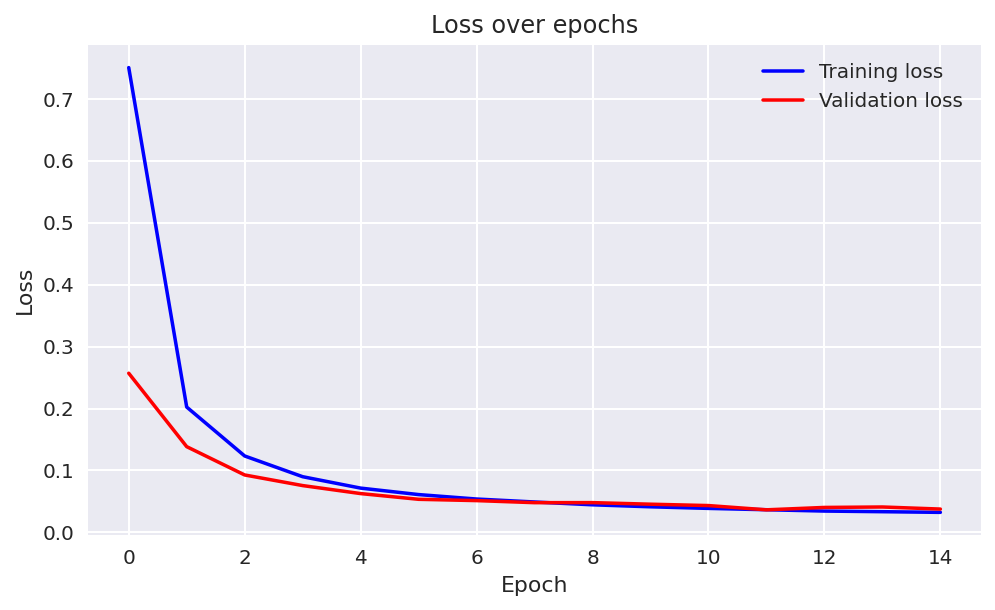

In [20]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

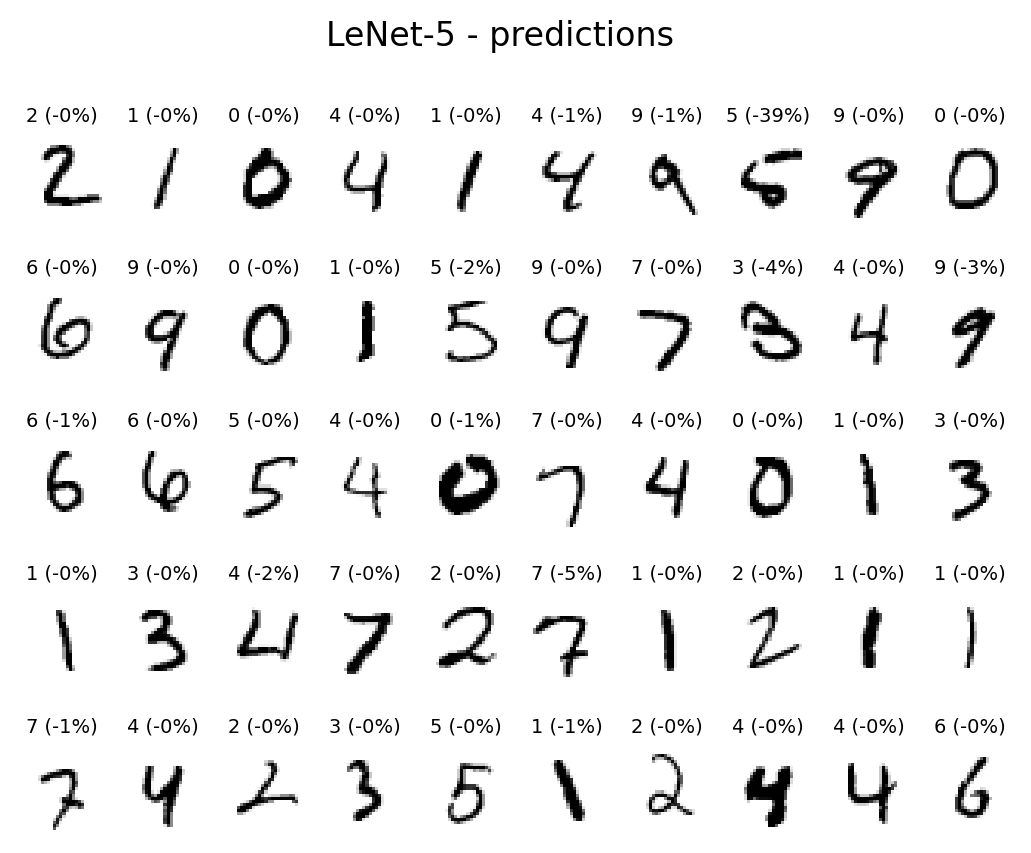

In [21]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()

for index in range(1, ROW_IMG * N_ROWS + 1):
    
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0).to(DEVICE))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)

fig.suptitle('LeNet-5 - predictions');